In [37]:
import importlib, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import importlib.machinery

lauglim = importlib.machinery.SourceFileLoader('lauglim','/Users/suelynnren/Documents/tasksuite_analysis/tasks/lauglim.py').load_module()
utils = importlib.machinery.SourceFileLoader('utils','/Users/suelynnren/Documents/tasksuite_analysis/tasks/utils.py').load_module()



In [3]:
import inspect
src = inspect.getsource(lauglim)

In [6]:
sessionTest='/Users/suelynnren/Documents/tasksuite_nb/resources/datasets/matching_fix/TG021/TG021_Matching_Aug23_2018_Session1.mat'

In [7]:
x=lauglim.parseSess(sessionTest)

# Running Thiago's Code --> after checking that code is running

In [8]:
home='/Users/suelynnren/Documents/tasksuite_nb/'

In [9]:
# No settings file for TG016_Matching_Mar01_2017_Session3

df_tidy_trials = utils.tidy_trials(fun = lauglim,
                             datadir = os.path.join(home,'resources','datasets','matching_fix'),
                             forcerun = False) # call to function tidy_trials imported from package tasks
df_tidy_trials = df_tidy_trials.loc[(df_tidy_trials.isChoiceLeft | df_tidy_trials.isChoiceRight),:] # removing trials where no choice was registered
eg_sess = df_tidy_trials.loc[df_tidy_trials.sess == 'TG021_Matching_Aug23_2018_Session1.mat',:].copy() # filtering dataframe for example session
display(eg_sess.loc[:,['isChoiceLeft', 'isChoiceRight', 'isRewarded','isBrokeFix','isEarlyWithdr',
                       'isLeftHi','isBaitLeft','isBaitRight','isChoiceBaited',
                       'waitingTime','reactionTime','movementTime','pLo','pHi']].head(5)) # displaying top rows and selected columns of example session

Reading dataframe from file.


,isChoiceLeft,isChoiceRight,isRewarded,isBrokeFix,isEarlyWithdr,isLeftHi,isBaitLeft,isBaitRight,isChoiceBaited,waitingTime,reactionTime,movementTime,pLo,pHi
iTrial,,,,,,,,,,,,,,
0,True,False,True,False,False,True,True,True,True,1.0001,0.6546,0.2798,5.0,40.0
1,False,True,True,False,False,True,True,True,True,1.0001,0.0492,0.2701,5.0,40.0
2,False,True,False,False,False,True,True,False,False,2.0812,0.0538,0.2579,5.0,40.0
3,True,False,True,False,False,True,True,False,True,1.0001,0.3230,0.3012,5.0,40.0
4,False,True,False,False,False,True,False,False,False,2.0602,0.4952,0.2418,5.0,40.0


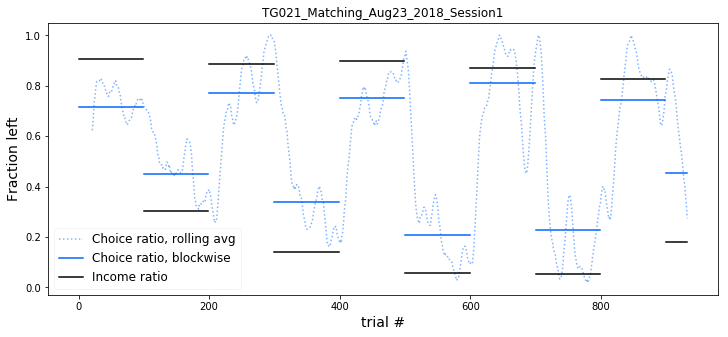

In [10]:
plt.figure(figsize=(12,5))
plt.plot(eg_sess.isChoiceLeft.rolling(20, win_type='gaussian').mean(std=5),':',color='xkcd:bright blue',alpha=.5,label='Choice ratio, rolling avg')
if 'labelRwd' in locals(): del labelRwd
if 'labelCho' in locals(): del labelCho
for iBlock in eg_sess.iBlock.drop_duplicates().values:
    ndx = eg_sess.iBlock==iBlock
    blockEdges = np.percentile(eg_sess.loc[ndx].index,[0,100])
    labelCho = '' if 'labelCho' in locals() else 'Choice ratio, blockwise'
    plt.plot(blockEdges,
             np.ones(2)*eg_sess.loc[ndx,'isChoiceLeft'].mean(),
            color='xkcd:bright blue',label=labelCho)
    labelRwd = '' if 'labelRwd' in locals() else 'Income ratio'
    plt.plot(blockEdges,
             np.ones(2)*(eg_sess.loc[ndx,'isRewarded'] & eg_sess.loc[ndx,'isChoiceLeft']).sum()/eg_sess.loc[ndx,'isRewarded'].sum(),
             color='xkcd:black',label=labelRwd)

plt.xlabel('trial #',fontsize=14)
plt.ylabel('Fraction left',fontsize=14)
plt.title(eg_sess.sess.drop_duplicates().values.item().split('.')[0])
plt.legend(fontsize=12,framealpha=.2)

## UNCOMENT TO PLOT INDIVIDUAL CHOICES
# plt.plot(eg_sess.isChoiceLeft.loc[eg_sess.isRewarded==0],'o',color='xkcd:red',alpha=.3)
# plt.plot(eg_sess.isChoiceLeft.loc[eg_sess.isRewarded],'o',color='xkcd:green',alpha=.3)

In [11]:
np.unique(eg_sess.iBlock, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8),
 array([91, 89, 92, 94, 92, 97, 95, 93, 89, 33]))

# Modeling Single Trial Decisions

Lau & Glimcher 2005. "c is the choice on each trial and is binary...r is the magnitude of reinforcement in mL of water received...The alpha and beta coeffcients measure the influence of past reinforcers (r) and choices (c), and the intercept term gamma captures preferences not accounted for..similar to the bias term in generalized matching law."


$$\log(P_\text{R,i}/P_\text{L,i})=( \sum_{j=1}^{nTrialsBack} \alpha_\text{j} (r_\text{R, i-j} - r_\text{L,i-j}) + \sum_{j=1}^{nTrialsBack} \beta_\text{j} (c_\text{R, i-j} - c_\text{L,i-j}) + \gamma$$

In [298]:
def lrdesign(df,nTrialsBack=10):
    # df is a tidy_trials dataframe - e.g. output of lauglim.parseSess()
    # nTrialsBack is an int defining length of trial history to be considered

    df = df.loc[(df.isChoiceLeft|df.isChoiceRight),:] # discard trials where no choice was recorded
    
    y = df.isChoiceLeft.astype(int); y[y==0] = -1 # outcome variable in {-1,1}
    tempR = np.multiply(y,df.isRewarded)
    X = pd.DataFrame(columns=['C-{0:0>2}'.format(i) for i in range(1,nTrialsBack+1)]+['R-{0:0>2}'.format(i) for i in range(1,nTrialsBack+1)],
                     index=df.index,data=0,dtype=int)
    for i in range(nTrialsBack):
        X.iloc[i+1:,X.columns.get_loc('C-{0:0>2}'.format(i+1))] = y.values[:-i-1]
        X.iloc[i+1:,X.columns.get_loc('R-{0:0>2}'.format(i+1))] = tempR.values[:-i-1]
        
    return X, y

In [299]:
from sklearn import linear_model

X,y =lrdesign(eg_sess,nTrialsBack=20)
mdl = linear_model.LogisticRegression(solver='lbfgs').fit(X=X,y=y)

In [300]:
eg_sess['dv'] = mdl.intercept_ + X @ mdl.coef_.T # decision variable 
eg_sess['dv_binned'], bins = pd.qcut(eg_sess['dv'],q=8,precision=1,retbins=True)
pivot = eg_sess.pivot_table(values='isChoiceLeft',index='dv_binned')
display(pivot)

,isChoiceLeft
dv_binned,
"(-4.8, -2.2]",0.055046
"(-2.2, -1.1]",0.092593
"(-1.1, -0.2]",0.351852
"(-0.2, 0.4]",0.574074
"(0.4, 1.0]",0.712963
"(1.0, 1.7]",0.768519
"(1.7, 2.6]",0.879630
"(2.6, 5.4]",0.972222


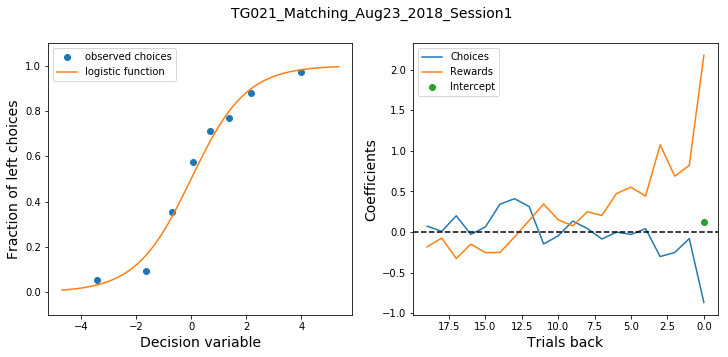

In [15]:
hf, ha = plt.subplots(1,2,figsize=(12,5))


ha[0].plot(pd.Series(bins).rolling(2).mean().dropna(), pivot.values.ravel(),'o',label='observed choices')
xdata = np.linspace(eg_sess['dv'].min(),eg_sess['dv'].max(),100)
ydata = 1./(1+np.exp(-xdata))
ha[0].plot(xdata,ydata,label='logistic function')
ha[0].set_ylim((-.1,1.1))
ha[0].set_xlabel('Decision variable',fontsize=14)
ha[0].set_ylabel('Fraction of left choices',fontsize=14)
ha[0].legend()

ha[1].plot(mdl.coef_[0][[col.startswith('C') for col in X.columns]],label='Choices')
ha[1].plot(mdl.coef_[0][[col.startswith('R') for col in X.columns]],label='Rewards')
ha[1].plot(0,mdl.intercept_,'o',label='Intercept')
ha[1].set_xlabel('Trials back',fontsize=14)
ha[1].set_ylabel('Coefficients',fontsize=14)
ha[1].legend()

hf.suptitle(eg_sess.sess.drop_duplicates().values.item().split('.')[0],fontsize=14)
plt.gca().invert_xaxis()
plt.axhline(y=0, color='black', linestyle='--')

In [16]:
def AnalysisPlots(dfTidy, nTrialsBack):
    X = dict()
    y = dict()
    pivot = dict()
    mdl = dict()

    listSubj = dfTidy['subj'].drop_duplicates()
    nSubj = len(listSubj)
    hf, ha = plt.subplots(nSubj,2,figsize=(6,nSubj*3),sharex='col',sharey='col')


    for isubj, subj in enumerate(listSubj):
        df_subj = dfTidy.loc[dfTidy['subj'] == subj,:].copy()
        listSess = df_subj['sess'].drop_duplicates()
        for isess, sess in enumerate(listSess):
            tempX, tempy = lrdesign(df_subj.loc[df_subj['sess'] == sess,:],nTrialsBack=nTrialsBack)
            X[subj] = pd.concat((X[subj],tempX)) if subj in X.keys() else tempX
            y[subj] = pd.concat((y[subj],tempy)) if subj in y.keys() else tempy
        mdl[subj] = linear_model.LogisticRegression(solver='lbfgs').fit(X=X[subj],y=y[subj])
        df_subj['dv'] = mdl[subj].intercept_ + X[subj] @ mdl[subj].coef_.T
        df_subj['dv_binned'] = pd.qcut(df_subj['dv'],q=8,precision=1,retbins=False)
        pivot[subj] = df_subj.pivot_table(values=['dv','isChoiceLeft'],index='dv_binned').round(2)

        ha[isubj,0].plot(pivot[subj]['dv'], pivot[subj]['isChoiceLeft'],'o',label='observed choices')
        xdata = np.linspace(df_subj['dv'].min(),df_subj['dv'].max(),100)
        ydata = 1./(1+np.exp(-xdata))
        ha[isubj,0].plot(xdata,ydata,label='logistic function')
        # ha[isubj,0].set_ylim((-.1,1.1))
        ha[isubj,0].set_title(subj)

        ha[isubj,1].plot(mdl[subj].coef_[0][[col.startswith('C') for col in X[subj].columns]],label='Choices')
        ha[isubj,1].plot(mdl[subj].coef_[0][[col.startswith('R') for col in X[subj].columns]],label='Rewards')
        ha[isubj,1].plot(0,mdl[subj].intercept_,'o',label='Intercept')

        if isubj == 0:
            ha[isubj,0].legend()
            ha[isubj,1].legend()
        if isubj == nSubj-1:
            ha[isubj,0].set_xlabel('Decision variable',fontsize=14),
            ha[isubj,0].set_ylabel('Fraction of left choices',fontsize=14)
            ha[isubj,1].set_xlabel('Trials back',fontsize=14),
            ha[isubj,1].set_ylabel('Coefficients',fontsize=14)
    return(X,y,pivot,mdl)

In [20]:
(mdl[i].intercept_ + X[i] @ mdl[i].coef_.T).index

Int64Index([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            651, 652, 653, 654, 655, 656, 657, 659, 660, 661],
           dtype='int64', name='iTrial', length=8567)

In [21]:
listSubj = df_tidy_trials['subj'].drop_duplicates()

for i in listSubj:
    df_tidy_trials.loc[df_tidy_trials.subj==i,'dv']=(mdl[i].intercept_ + X[i] @ mdl[i].coef_.T).values

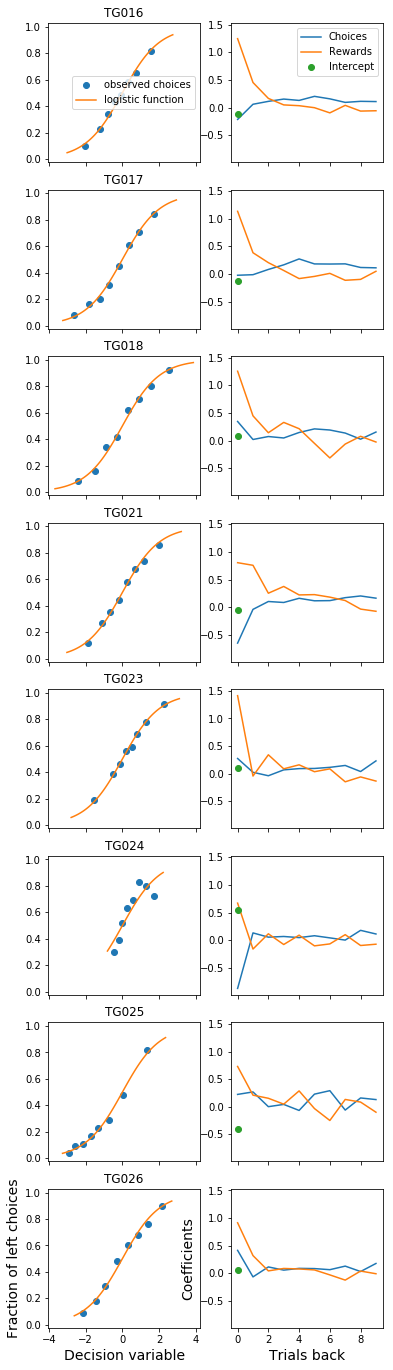

In [19]:
X,y,_, mdl=AnalysisPlots(df_tidy_trials, 10)

# Replicating figures from Lau & Glimcher 2005

Lau & Glimcher 2005: Fig 7

In [22]:
_,blockIdx=np.unique(eg_sess.iBlock, return_index='first')
blockIdx
blockEdge=eg_sess.index[blockIdx]
blockEdge

Int64Index([0, 100, 200, 300, 400, 500, 600, 700, 800, 900], dtype='int64', name='iTrial')

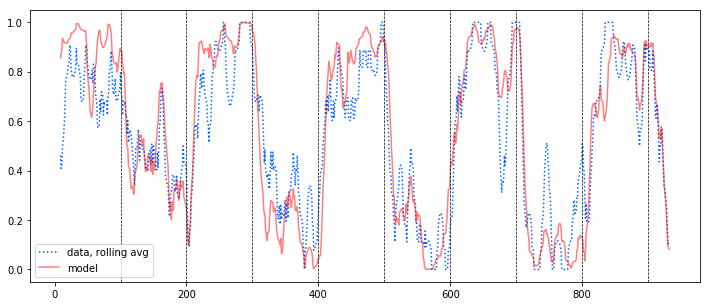

In [50]:
_,blockIdx=np.unique(eg_sess.iBlock, return_index='first')
blockEdge=eg_sess.index[blockIdx]

plt.figure(figsize=(12,5))
plt.plot(eg_sess.isChoiceLeft.rolling(10, win_type='gaussian').mean(std=5),':',\
         color='xkcd:bright blue',alpha=1,label='data, rolling avg')

modelPL=10**(eg_sess['dv'])/(1+10**(eg_sess['dv']))

plt.plot(modelPL.rolling(10, win_type='gaussian').mean(std=5), alpha=0.5, color='r', label='model')

for xc in blockEdge[1:]:
    plt.axvline(x=xc, color='black', linestyle='--',linewidth=0.7)
plt.legend()

In [27]:
#trialbytrial plot takes a tidy_df of a single subject and session (initially tested with eg_sess)
def TrialbyTrialPlot(df,npoint_avg):
            
    _,blockIdx=np.unique(df.iBlock, return_index='first')
    blockEdge=df.index[blockIdx]

    plt.figure(figsize=(12,5))
    plt.plot(df.isChoiceLeft.rolling(npoint_avg, win_type='gaussian').mean(std=5),':',\
             color='xkcd:bright blue',alpha=1,label='data, rolling avg')

    modelPL=10**(df['dv'])/(1+10**(df['dv']))

 c
    for xc in blockEdge[1:]:
        plt.axvline(x=xc, color='black', linestyle='--',linewidth=0.7)
    plt.legend()

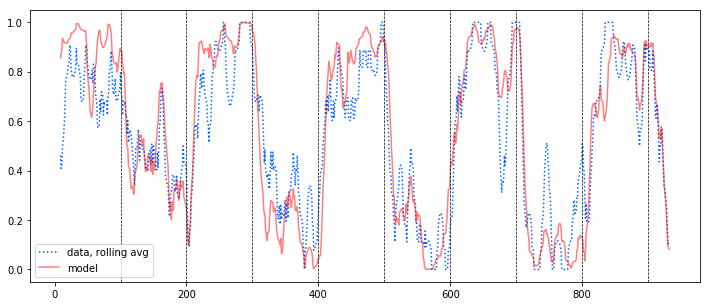

In [29]:
TrialbyTrialPlot(eg_sess, 10)

Fig 8: Responses to block transitions, probability of choosing the alternative that was richer following an unsignalled block transition. Probabilities computed by averaging choices for trials preceding and following a block transition 

In [30]:
eg_sess.loc[:,'model_PL']=modelPL

In [31]:
eg_sess.loc[blockEdge,['iBlock','isChoiceLeft','isLeftHi']]
numTransitions=len(blockEdge)-2
preTrialNum=25
postTrialNum=65

iTrial=np.arange(0-preTrialNum, 0+postTrialNum)
Df_AltChoice=pd.DataFrame(np.zeros((preTrialNum+postTrialNum,numTransitions)))
Df_AltChoice.loc[:,'modelEstimate']=np.zeros((preTrialNum+postTrialNum,1))
Df_AltChoice.index=iTrial

for num, thisEdge in enumerate(blockEdge[1:-1]):
    transitionPre=thisEdge-preTrialNum
    transitionPost=thisEdge+postTrialNum
    
    #df_tmp=eg_sess[eg_sess.index.isin(np.arange(transitionPre,transitionPost))]
    df_tmp=eg_sess.loc[pd.np.r_[transitionPre:transitionPost]]
    if df_tmp.isLeftHi.loc[thisEdge-1]:
        Df_AltChoice.iloc[:,num]=df_tmp.isChoiceRight.values
        Df_AltChoice.loc[:, 'modelEstimate']=1-(df_tmp.model_PL.values)
    else:
        Df_AltChoice.iloc[:,num]=df_tmp.isChoiceLeft.values
        Df_AltChoice.loc[:, 'modelEstimate']=df_tmp.model_PL.values

Df_AltChoice.loc[:,'meanResponse']=Df_AltChoice.iloc[:,0:numTransitions].mean(axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()


Text(0,0.5,'Probability of choosing the \n altternative that is richer following transition')

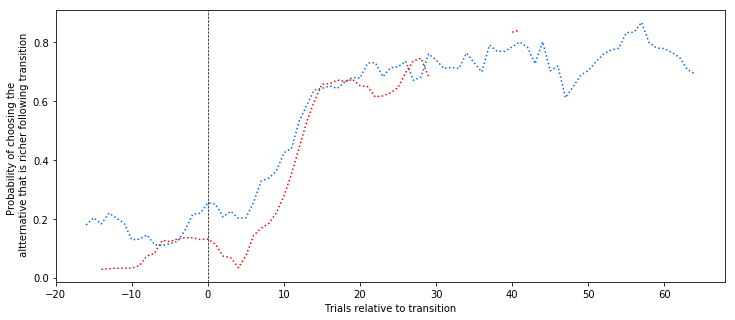

In [32]:
plt.figure(figsize=(12,5))
plt.plot(Df_AltChoice.iloc[:,0:numTransitions].rolling(10, win_type='gaussian').mean(std=5).mean(axis=1),':',\
         color='xkcd:bright blue',alpha=1,label='data, rolling avg')

plt.plot(Df_AltChoice.modelEstimate.rolling(10, win_type='gaussian').mean(std=5),':',\
         color='red',alpha=1,label='data, rolling avg')
plt.axvline(x=0, color='black', linestyle='--',linewidth=0.7)
plt.xlabel('Trials relative to transition')
plt.ylabel('Probability of choosing the \n altternative that is richer following transition')

In [33]:
    #makes indexing easier, iTrial is not consecutive bc missed and early withd. trials
    #are thrown out in ln[6].
    
    def transitionPlot(df):
        workingDf=df.copy().reset_index()
        _,blockIdx=np.unique(workingDf.iBlock, return_index='first')
        
        df.loc[blockEdge,['iBlock','isChoiceLeft','isLeftHi']]
        numTransitions=len(blockEdge)-2
        preTrialNum=25
        postTrialNum=65

        iTrial=np.arange(0-preTrialNum, 0+postTrialNum)
        Df_AltChoice=pd.DataFrame(np.zeros((preTrialNum+postTrialNum,numTransitions)))
        Df_AltChoice.loc[:,'modelEstimate']=np.zeros((preTrialNum+postTrialNum,1))
        Df_AltChoice.index=iTrial

        for num, thisEdge in enumerate(blockEdge[1:-1]):
            transitionPre=thisEdge-preTrialNum
            transitionPost=thisEdge+postTrialNum

            #df_tmp=eg_sess[eg_sess.index.isin(np.arange(transitionPre,transitionPost))]
            df_tmp=eg_sess.loc[pd.np.r_[transitionPre:transitionPost]]
            if df_tmp.isLeftHi.loc[thisEdge-1]:
                Df_AltChoice.iloc[:,num]=df_tmp.isChoiceRight.values
                Df_AltChoice.loc[:, 'modelEstimate']=1-(df_tmp.model_PL.values)
            else:
                Df_AltChoice.iloc[:,num]=df_tmp.isChoiceLeft.values
                Df_AltChoice.loc[:, 'modelEstimate']=df_tmp.model_PL.values

        Df_AltChoice.loc[:,'meanResponse']=Df_AltChoice.iloc[:,0:numTransitions].mean(axis=1)


In [34]:
#def transitionPlot is still pretty buggy

In [38]:
#takes a tidy trials df - df must include dv from linear regression.
def transitionPlot(df_tidy_trials, borderTrials, subject):
    dummyDf=df_tidy_trials.copy()
    
    #filters df for the subject and finds different pLo and pHi frequencies across sessions
    ratDf=dummyDf.loc[dummyDf.subj==subject,:]
    ratDf['deltaFreq'] = ratDf['pLo'].astype(str) + ratDf['pHi'].astype(str)
    rewardFreq=np.unique(ratDf['deltaFreq'])
    
    RatDf_PlotFreq=pd.DataFrame({'data':[], 'model':[],'freqCondition':[]})
    
    #for each reward frequency pairing:
    for num,j in enumerate(rewardFreq):
        freqDf_dummy=ratDf.loc[ratDf.deltaFreq==j, ['iBlock','isChoiceLeft','isLeftHi','sess','dv','deltaFreq']].reset_index()
        blckIdx=[]
        
        # for each session, find all blocks where the reward prob. switches, exclude the first and last block of a reward freq pair
        # The first block is usually block 1, except when something buggy happens and the reward prob. changes wihin the session.
        # The last block is often truncated and not enough trials to reach stable behavior
        for k in np.unique(freqDf_dummy.sess):
            tmpDf=freqDf_dummy.loc[freqDf_dummy.sess==k,'iBlock']
            _,tmpIdx=np.unique(tmpDf, return_index=True)

            Idx=tmpDf.iloc[tmpIdx].index.values
            blckIdx=np.concatenate([blckIdx,Idx[1:]])
        
            borderStart=blckIdx-borderTrials
            borderEnd=blckIdx+borderTrials

            blckIdx=np.delete(blckIdx, np.where(borderEnd>freqDf_dummy.index[-1]))


            #slice the pd df to only take borders of each block transition    
            #AltChoice=pd.concat([freqDf_dummy.loc[pd.np.r_[y:z]] for (y,z) in zip(borderStart, borderEnd)]).sort_index(axis=1)
            AltChoice=pd.concat([freqDf_dummy.loc[pd.np.r_[iii-borderTrials:iii+borderTrials]] for iii in blckIdx]).sort_index(axis=1)
            AltChoice=AltChoice.drop_duplicates(keep='first')
            
            #for each block find the rich response and the model estimate
    
            full_x=pd.DataFrame()
        for edge in blckIdx:
            pd_slice=np.arange(edge-borderTrials,edge+borderTrials)
            #index is for the first trial of the next block, if left is high, rich choice is now left

            if AltChoice.loc[AltChoice.index==edge].isLeftHi.values:
                    AltChoice.loc[AltChoice.index.isin(pd_slice),'RichResponse'] = AltChoice.loc\
                    [AltChoice.index.isin(pd_slice),'isChoiceLeft']

                    dv=AltChoice.loc[AltChoice.index.isin(pd_slice),'dv'].values
                    probabilityLeft=10**dv/(1+10**dv)

                    AltChoice.loc[AltChoice.index.isin(pd_slice),'ModelEstimate'] = probabilityLeft
            else:
                    AltChoice.loc[AltChoice.index.isin(pd_slice),'RichResponse'] = ~AltChoice.loc\
                    [AltChoice.index.isin(pd_slice),'isChoiceLeft']

                    dv=AltChoice.loc[AltChoice.index.isin(pd_slice),'dv'].values
                    probabilityLeft=10**dv/(1+10**dv)

                    AltChoice.loc[AltChoice.index.isin(pd_slice),'ModelEstimate'] = 1-probabilityLeft

            dummy_df=AltChoice.loc[AltChoice.index.isin(pd_slice)].reset_index()
            #print(len(dummy_df))
            #print(dummy_df)
    
            full_x=pd.concat([full_x,dummy_df],axis=1)
            

                #stack plt_pAlt for averaging etc and store it FreqDf dict
                #x=pd.concat([AltChoice.loc[AltChoice.index.isin(pd_slice)].reset_index() for kk in blckIdx], axis=1).sort_index(axis=1)
        full_x.index=np.arange(-borderTrials, borderTrials)
        
        
        xx_data=full_x.RichResponse.rolling(10, win_type='gaussian').mean(std=5).mean(axis=1)
        xx_model=full_x.ModelEstimate.rolling(10, win_type='gaussian').mean(std=5).mean(axis=1)
        xx_freq=j
        
        xx_tmpDf=pd.DataFrame({'data':xx_data, 'model': xx_model,'freqCondition': xx_freq})
    
        RatDf_PlotFreq=pd.concat([RatDf_PlotFreq, xx_tmpDf])
        del AltChoice, blckIdx, dummy_df, full_x

    fig=plt.figure(figsize=(12,5))
    
    ax=sns.lineplot(x=RatDf_PlotFreq.index, y=RatDf_PlotFreq.model,hue=RatDf_PlotFreq.freqCondition,data=RatDf_PlotFreq)
    for num, i in enumerate(ax.lines):
        ax.lines[num].set_linestyle("--")
        
        
    sns.lineplot(x=RatDf_PlotFreq.index, y=RatDf_PlotFreq.data,hue=RatDf_PlotFreq.freqCondition, data=RatDf_PlotFreq)



 
        #plt.plot(x.RichResponse.rolling(10, win_type='gaussian').mean(std=5).mean(axis=1),':',\
        #             color='xkcd:bright blue',alpha=1,label='data, rolling avg')

        #plt.plot(x.ModelEstimate.rolling(10, win_type='gaussian').mean(std=5).mean(axis=1),':',\
        #             color='red',alpha=1,label='model, rolling avg')
        
    plt.axvline(x=0, color='black', linestyle='--',linewidth=0.7)
    plt.xlabel('Trials relative to transition')
    plt.ylabel('Probability of choosing the \n altternative that is richer following transition')

    txt_freq=j.split('.0')
    txt=f" Frequency Condition: {txt_freq[0]} : {txt_freq[1]}."
    fig.text(0.35, 0.74, txt, family='monospace')
    plt.legend()



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


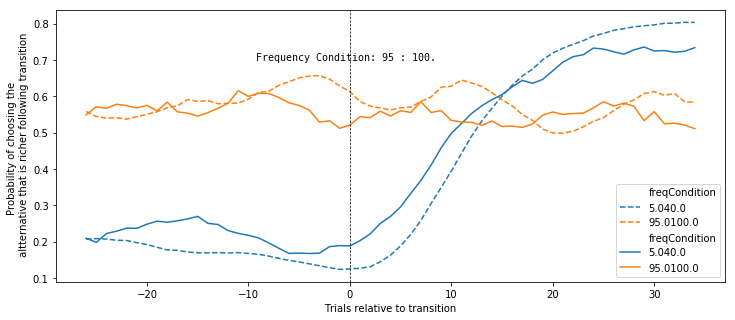

In [39]:
transitionPlot(df_tidy_trials, 35, 'TG021')

Residual analysis Fig 9: 

In [462]:
def lrdesignR(df,nTrialsBack=10):
    # df is a tidy_trials dataframe - e.g. output of lauglim.parseSess()
    # nTrialsBack is an int defining length of trial history to be considered

    df = df.loc[(df.isChoiceLeft|df.isChoiceRight),:] # discard trials where no choice was recorded
    
    y = df.isChoiceLeft.astype(int); y[y==0] = -1 # outcome variable in {-1,1}
    tempR = np.multiply(y,df.isRewarded)
    X = pd.DataFrame(columns=['R-{0:0>2}'.format(i) for i in range(1,nTrialsBack+1)],
                     index=df.index,data=0,dtype=int)
    for i in range(nTrialsBack):
        #X.iloc[i+1:,X.columns.get_loc('C-{0:0>2}'.format(i+1))] = y.values[:-i-1]
        X.iloc[i+1:,X.columns.get_loc('R-{0:0>2}'.format(i+1))] = tempR.values[:-i-1]
        
    return X, y

def lrdesignC(df,nTrialsBack=10):
    # df is a tidy_trials dataframe - e.g. output of lauglim.parseSess()
    # nTrialsBack is an int defining length of trial history to be considered

    df = df.loc[(df.isChoiceLeft|df.isChoiceRight),:] # discard trials where no choice was recorded
    
    y = df.isChoiceLeft.astype(int); y[y==0] = -1 # outcome variable in {-1,1}
    tempR = np.multiply(y,df.isRewarded)
    X = pd.DataFrame(columns=['C-{0:0>2}'.format(i) for i in range(1,nTrialsBack+1)],
                     index=df.index,data=0,dtype=int)
    for i in range(nTrialsBack):
        X.iloc[i+1:,X.columns.get_loc('C-{0:0>2}'.format(i+1))] = y.values[:-i-1]
        #X.iloc[i+1:,X.columns.get_loc('R-{0:0>2}'.format(i+1))] = tempR.values[:-i-1]
        
    return X, y

In [463]:
def residualModel(df):
    #full model
    X,y =lrdesign(df,nTrialsBack=20)
    mdl = linear_model.LogisticRegression(solver='lbfgs').fit(X=X,y=y)
    
    #reinforcement removed from model
    XC,yC =lrdesignC(df,nTrialsBack=20)
    mdl_C = linear_model.LogisticRegression(solver='lbfgs').fit(X=XC,y=yC)

    #choice removed from model
    XR,yR =lrdesignR(df,nTrialsBack=20)
    mdl_R = linear_model.LogisticRegression(solver='lbfgs').fit(X=XR,y=yR)

    model = mdl.intercept_ + X @ mdl.coef_.T # decision variable
    modelC = mdl_C.intercept_ + XC @ mdl_C.coef_.T # decision variable 
    modelR = mdl_R.intercept_ + XR @ mdl_R.coef_.T # decision variable 
    
    modelPL=10**(model)/(1+10**(model))
    modelPL_C=10**(modelC)/(1+10**(modelC))
    modelPL_R=10**(modelR)/(1+10**(modelR))
    
    return(pd.Series(modelPL.values.flatten()), pd.Series(modelPL_C.values.flatten()), pd.Series(modelPL_R.values.flatten()))
    #return(modelPL.reindex(),modelPL_C.reindex(), modelPL_R.reindex())

In [464]:
data=pd.Series(df_tidy_trials.loc[df_tidy_trials.subj=='TG021', 'isChoiceLeft'].values)
PL, PL_C, PL_R=residualModel(df_tidy_trials.loc[df_tidy_trials.subj=='TG021',:])

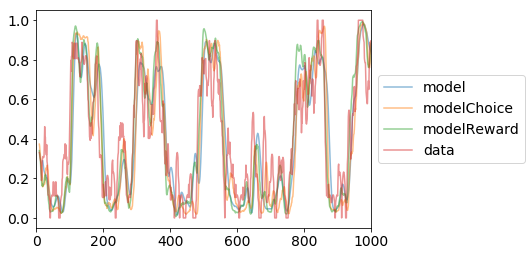

In [646]:
plt.plot(PL.rolling(20, win_type='gaussian').mean(std=5), alpha=0.5,  label='model')
plt.plot(PL_C.rolling(10, win_type='gaussian').mean(std=5), alpha=0.5,  label='modelChoice')
plt.plot(PL_R.rolling(10, win_type='gaussian').mean(std=5), alpha=0.5,  label='modelReward')
plt.plot(data.rolling(10, win_type='gaussian').mean(std=5), alpha=0.5,  label='data')

plt.xlim(0,1000)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [468]:
dfResidual=data-PL
dfResidualC=data-PL_C
dfResidualR=data-PL_R

In [515]:
full=[]
choice=[]
reward=[]
for i in np.arange(1,50):
    xx=dfResidual.autocorr(lag=i)
    cc=dfResidualC.autocorr(lag=i)
    rr=dfResidualR.autocorr(lag=i)
    
    full=np.hstack((full,xx))
    choice=np.hstack((choice,cc))
    reward=np.hstack((reward,rr))

(-0.2, 0.2)

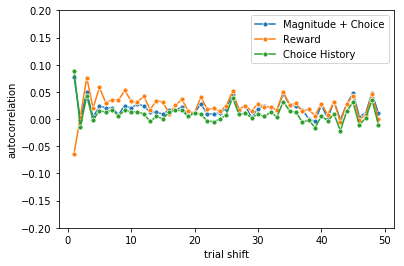

In [537]:
sns.lineplot(x=np.arange(1,50), y=full,marker='o', markersize=5, label='Magnitude + Choice')
sns.lineplot(x=np.arange(1,50), y=reward, marker='o', markersize=5, label='Reward')
sns.lineplot(x=np.arange(1,50), y=choice, marker='o', markersize=5, label='Choice History')



plt.ylabel('autocorrelation')
plt.xlabel('trial shift')
plt.ylim(-0.2, 0.2)

In [622]:
x=np.arange(1, len(full)*10+1, 10)
xx=x+1.5
xxx=x+3

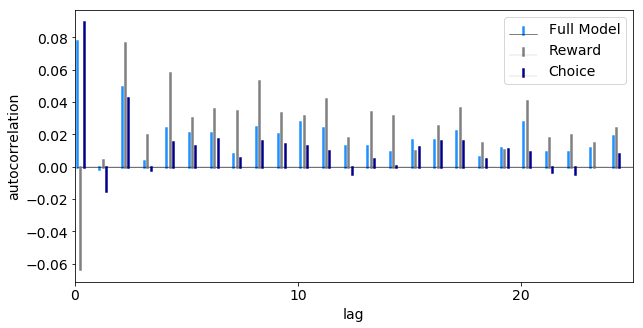

In [636]:
plt.figure(figsize=(10,5))
markerline, stemlines, baseline=plt.stem(x,full, markerfmt=" ", label='Full Model')
markerlineR, stemlinesR, baselineR=plt.stem(xx,reward, markerfmt=" ",  label='Reward')
markerlineC, stemlinesC, baselineC=plt.stem(xxx,choice,markerfmt=" ", label='Choice')

plt.setp(baseline, color='k', linewidth=0.5)
plt.setp(baselineR, color='k', linewidth=0.1)
plt.setp(baselineC, color='k', linewidth=0.1)


plt.setp(stemlines, color='dodgerblue', linewidth=2.5)
plt.setp( stemlinesR, color='grey', linewidth=2.5)
plt.setp(stemlinesC, color='darkblue', linewidth=2.5)

ticklabels=['0','10','20','30','40','50']

positions = (0, 100, 200,300,400,500)

plt.xticks(positions, ticklabels)
plt.xlim(0,250)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.rcParams.update({'font.size': 14})
plt.legend()

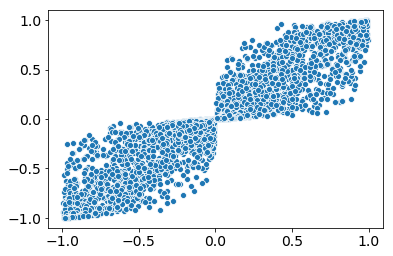

In [640]:
sns.scatterplot(dfResidualC, dfResidualR)